In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
%cd /content/drive/MyDrive/CS114-GiaHan/Task 2

/content/drive/MyDrive/CS114-GiaHan/Task 2


In [60]:
%%capture
!pip install pandas openpyxl
!pip install odfpy

In [61]:
!pip install catboost

# Thư viện

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer, r2_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [63]:
# df_qt = pd.read_csv('/kaggle/input/data-cs114-task-2/data/public_it001/qt-public.csv')
# df_tbtl = pd.read_excel('/kaggle/input/data-cs114-task-2/data/data-tbtl/tbtl-public.ods', engine='odf')
# df_th = pd.read_csv('/kaggle/input/data-cs114-task-2/data/public_it001/th-public.csv')
# df_ck = pd.read_csv('/kaggle/input/data-cs114-task-2/data/public_it001/ck-public.csv')
# df = pd.read_csv("/kaggle/input/data-cs114-task-2/data/data-tbtl/annonimized.csv")

df_qt = pd.read_csv('/content/drive/MyDrive/CS114-GiaHan/Task 2/data/public_it001/qt-public.csv')
df_tbtl = pd.read_excel('/content/drive/MyDrive/CS114-GiaHan/Task 2/data/data-tbtl/tbtl-public.ods', engine='odf')
df_th = pd.read_csv('/content/drive/MyDrive/CS114-GiaHan/Task 2/data/public_it001/th-public.csv')
df_ck = pd.read_csv('/content/drive/MyDrive/CS114-GiaHan/Task 2/data/public_it001/ck-public.csv')
df = pd.read_csv("/content/drive/MyDrive/CS114-GiaHan/Task 2/data/data-tbtl/annonimized.csv")

# Preprocessing



## Tạo Đặc Trưng Mới Dựa Trên Các Cột Có Sẵn

In [64]:
# Đổi tên các cột để dễ sử dụng
df = df.rename(columns={"concat('it001',`problem_id`)": 'problem_id'})
df = df.rename(columns={"concat('it001', username)": 'username'})
df = df.rename(columns={"concat('it001',`assignment_id`)": 'assignment_id'})

In [65]:
# Tạo DataFrame df_statistics
df_final = pd.DataFrame()

### Tính tổng số problem và assignment mà sinh viên đó cần phải làm

In [66]:
# Nhóm theo username để lấy tổng số bài tập và bài kiểm tra
total_problems = df.groupby('username')['problem_id'].nunique()
total_assignments = df.groupby('username')['assignment_id'].nunique()

In [67]:
df_final['problem_total'] = total_problems
df_final['assignment_total'] = total_assignments

### Tính tỉ lệ nộp bài thành công

In [68]:
# Tính toán tỉ lệ nộp bài thành công và không thành công
success_submit = df[df['pre_score'] == 10000].groupby('username').size()
failed_submit = df[df['pre_score'] < 10000].groupby('username').size()
success_rate_avg = success_submit / (success_submit + failed_submit)
failed_rate_avg = failed_submit / (success_submit + failed_submit)

In [69]:
# Đảm bảo không có giá trị NaN
success_rate_avg.fillna(0, inplace=True)
failed_rate_avg.fillna(0, inplace=True)

In [70]:
df_final['success_rate_avg'] = success_rate_avg
df_final['failed_rate_avg'] = failed_rate_avg

In [71]:
df

,assignment_id,problem_id,username,is_final,status,pre_score,coefficient,"concat('it001',`language_id`)",created_at,updated_at,judgement
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
...,...,...,...,...,...,...,...,...,...,...,...
295193,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:43,01-15 16:03:53,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":..."
295194,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,0,Compilation Error,0,100,it0012,01-15 16:04:07,01-15 16:05:08,"{""times"":[],""mems"":[],""verdicts"":{""\n\nIn func..."
295195,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:04:58,01-15 16:05:08,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":..."
295196,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:05:13,01-15 16:05:22,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":[0..."


In [73]:
# Đếm số lần xuất hiện của các nhóm lỗi trực tiếp trong df_final
for group, strings in judgement_strings.items():
    df_final[group] = df.groupby('username')['judgement'].apply(
        lambda x: x.str.contains('|'.join(strings), case=False, na=False).sum()
    )

### Tính tỷ lệ hoàn thành bài tập trên 80%.



In [74]:
agg_df = df.groupby('username').agg(
    unique_assignment_id=('assignment_id', 'nunique'),
    unique_problem_id=('problem_id', 'nunique')
    ).reset_index()


In [75]:
# Tính toán tỷ lệ hoàn thành bài tập trên 80%
max_unique_assignment_id = agg_df['unique_assignment_id'].max()
max_unique_problem_id = agg_df['unique_problem_id'].max()

# Tính toán tỷ lệ hoàn thành assignment
agg_df['completion_assignment'] = agg_df['unique_assignment_id'] / max_unique_assignment_id

# Tính toán tỷ lệ hoàn thành problem
agg_df['completion_problem'] = agg_df['unique_problem_id'] / max_unique_problem_id

# Thêm hai cột thể hiện giá trị 1 nếu tỷ lệ hoàn thành bài tập lớn hơn hoặc bằng 80%, ngược lại là 0
agg_df['above_80_assignment'] = (agg_df['completion_assignment'] >= 0.8).astype(int)
agg_df['above_80_problem'] = (agg_df['completion_problem'] >= 0.8).astype(int)

In [76]:
df_final = df_final.merge(agg_df, on='username', how='left')

In [77]:
df_final.drop(columns=['unique_assignment_id', 'unique_problem_id'], inplace=True)

### Tính toán tỉ lệ nộp bài trễ

In [78]:
late_submissions = df[df['coefficient'] < 100]
late_cnt = late_submissions.groupby('username').size().reset_index(name='late_submission_count')
print(late_cnt)

                                     username  late_submission_count
0    013de369c439ab0ead8aa7da64423aa395a8be39                      3
1    0155f91fe242fe55e1af631b0f0afbe9938b185c                      1
2    052039d5c5915699359b1d549b36ea69330c0ac3                     14
3    05b134c1a682085880fb7ce76d221a48955e5b8a                     18
4    0a9b6ec3e82e8a2527b21eb3420a6d9b72f4f71e                     36
..                                        ...                    ...
106  f7875ec1207504a229cd9b5ca132437c6bdd6a4d                      7
107  f86b9fba1d59be7c864d4f23d0c7674113a27cab                     15
108  f9491b0ab4aee90c428545e0e315a3af1f827595                     20
109  f9f4d4ef2a3de006bd037db9eb160ab8e51c79f2                     50
110  fcd6e54df612c033e7a465155046b5223ca4eee3                      7

[111 rows x 2 columns]


In [79]:
late_submission_rate = df.groupby('username')['coefficient'].apply(lambda x: (x < 100).mean()).reset_index(name='late_submission_rate')
print(late_submission_rate)

                                      username  late_submission_rate
0     00b6dd4fc7eb817e03708c532016ef30ce564a61              0.000000
1     00bef8afee8f3c595d535c9c03c490cac1a4f021              0.000000
2     01122b3ef7e59b84189e65985305f575d6bdf83c              0.000000
3     0134f9f410c65ad0e8c2254a7e9288670e02a183              0.000000
4     013de369c439ab0ead8aa7da64423aa395a8be39              0.028037
...                                        ...                   ...
1484  feb8a2859a011c59efd22ed419cb69288fe03627              0.000000
1485  fef4a3263ed9a8ab14d457694bb8fd86ccd98312              0.000000
1486  ff12d6e2ab80696ed8e22fbe5497e96c68d29076              0.000000
1487  ff3fa2ec64294f37ae968159f810ebeda7966c51              0.000000
1488  ffe872165621d735a48bb5db0c71dd5195cba359              0.000000

[1489 rows x 2 columns]


In [80]:
df_final = df_final.merge(late_submission_rate, on='username', how='left')

### Tính số lượng ngày trung bình trong tuần mà sinh viên nộp bài

In [81]:
df

,assignment_id,problem_id,username,is_final,status,pre_score,coefficient,"concat('it001',`language_id`)",created_at,updated_at,judgement
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
...,...,...,...,...,...,...,...,...,...,...,...
295193,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:43,01-15 16:03:53,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":..."
295194,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,0,Compilation Error,0,100,it0012,01-15 16:04:07,01-15 16:05:08,"{""times"":[],""mems"":[],""verdicts"":{""\n\nIn func..."
295195,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:04:58,01-15 16:05:08,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":..."
295196,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:05:13,01-15 16:05:22,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":[0..."


In [82]:
# Đảm bảo 'created_at' và 'updated_at' có định dạng datetime
df['created_at'] = pd.to_datetime(df['created_at'], format='%m-%d %H:%M:%S',errors='coerce')
df['updated_at'] = pd.to_datetime(df['updated_at'], format='%m-%d %H:%M:%S',errors='coerce')

# Trích xuất số tuần và ngày trong tuần từ 'updated_at'
df['week_number'] = df['updated_at'].dt.isocalendar().week
df['day_of_week'] = df['updated_at'].dt.dayofweek

In [84]:
# Nhóm theo username, số tuần và ngày trong tuần để đếm số lần nộp bài
weekly_submissions = df.groupby(['username', 'week_number', 'day_of_week']).size().reset_index(name='submission_count')

# Nhóm theo username và số tuần để đếm số ngày có nộp bài trong mỗi tuần
days_per_week = weekly_submissions.groupby(['username', 'week_number']).size().reset_index(name='days_submitted')

# Tính toán số ngày trung bình có nộp bài trong mỗi tuần cho từng học sinh
average_days_per_week = days_per_week.groupby('username')['days_submitted'].mean().reset_index(name='avg_days_per_week')

# Kết hợp kết quả với df_final
df_final = df_final.merge(average_days_per_week, on='username', how='left')

# Điền giá trị NaN bằng 0 nếu có
df_final['avg_days_per_week'].fillna(0, inplace=True)

# Làm tròn giá trị ngày
df_final['avg_days_per_week'] = df_final['avg_days_per_week'].apply(lambda x: round(x * 2) / 2)


<ipython-input-84-313d7f9519eb>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['avg_days_per_week'].fillna(0, inplace=True)


### Tính điểm trung bình tất cả các pre_score, điểm trung bình is_final

In [85]:
pre_score_avg = df.groupby("username")['pre_score'].mean().reset_index(name='pre_score_avg')
print(pre_score_avg)

                                      username  pre_score_avg
0     00b6dd4fc7eb817e03708c532016ef30ce564a61    5504.149660
1     00bef8afee8f3c595d535c9c03c490cac1a4f021    5488.552124
2     01122b3ef7e59b84189e65985305f575d6bdf83c    5973.753846
3     0134f9f410c65ad0e8c2254a7e9288670e02a183    5952.760000
4     013de369c439ab0ead8aa7da64423aa395a8be39    6474.448598
...                                        ...            ...
1484  feb8a2859a011c59efd22ed419cb69288fe03627    5581.081081
1485  fef4a3263ed9a8ab14d457694bb8fd86ccd98312    6204.557692
1486  ff12d6e2ab80696ed8e22fbe5497e96c68d29076    4998.466819
1487  ff3fa2ec64294f37ae968159f810ebeda7966c51    4343.329787
1488  ffe872165621d735a48bb5db0c71dd5195cba359    6353.769424

[1489 rows x 2 columns]


In [86]:
final_submissions = df[df['is_final'] == 1]

score_avg = final_submissions.groupby("username")['pre_score'].mean().reset_index(name='score_avg')
print(score_avg)


                                      username     score_avg
0     00b6dd4fc7eb817e03708c532016ef30ce564a61  10000.000000
1     00bef8afee8f3c595d535c9c03c490cac1a4f021   9647.423077
2     01122b3ef7e59b84189e65985305f575d6bdf83c   9391.253731
3     0134f9f410c65ad0e8c2254a7e9288670e02a183  10000.000000
4     013de369c439ab0ead8aa7da64423aa395a8be39   9176.151515
...                                        ...           ...
1483  feb8a2859a011c59efd22ed419cb69288fe03627  10000.000000
1484  fef4a3263ed9a8ab14d457694bb8fd86ccd98312   9730.769231
1485  ff12d6e2ab80696ed8e22fbe5497e96c68d29076   9943.980583
1486  ff3fa2ec64294f37ae968159f810ebeda7966c51   9230.088235
1487  ffe872165621d735a48bb5db0c71dd5195cba359  10000.000000

[1488 rows x 2 columns]


In [87]:
df_final = df_final.merge(pre_score_avg, on='username', how='left')
df_final = df_final.merge(score_avg, on='username', how='left')

## Lựa chọn các feature phù hợp và xem xét độ tương quan giữa các feature

In [88]:
# Tạo bản sao của df_statistics để phân tích
full_df_temp = df_final.copy()

In [89]:
# Tính ma trận tương quan cho tất cả các cột ngoại trừ 'username'
full_df_temp_corr = full_df_temp.drop(columns=['username'])
corr_matrix = full_df_temp_corr.corr()

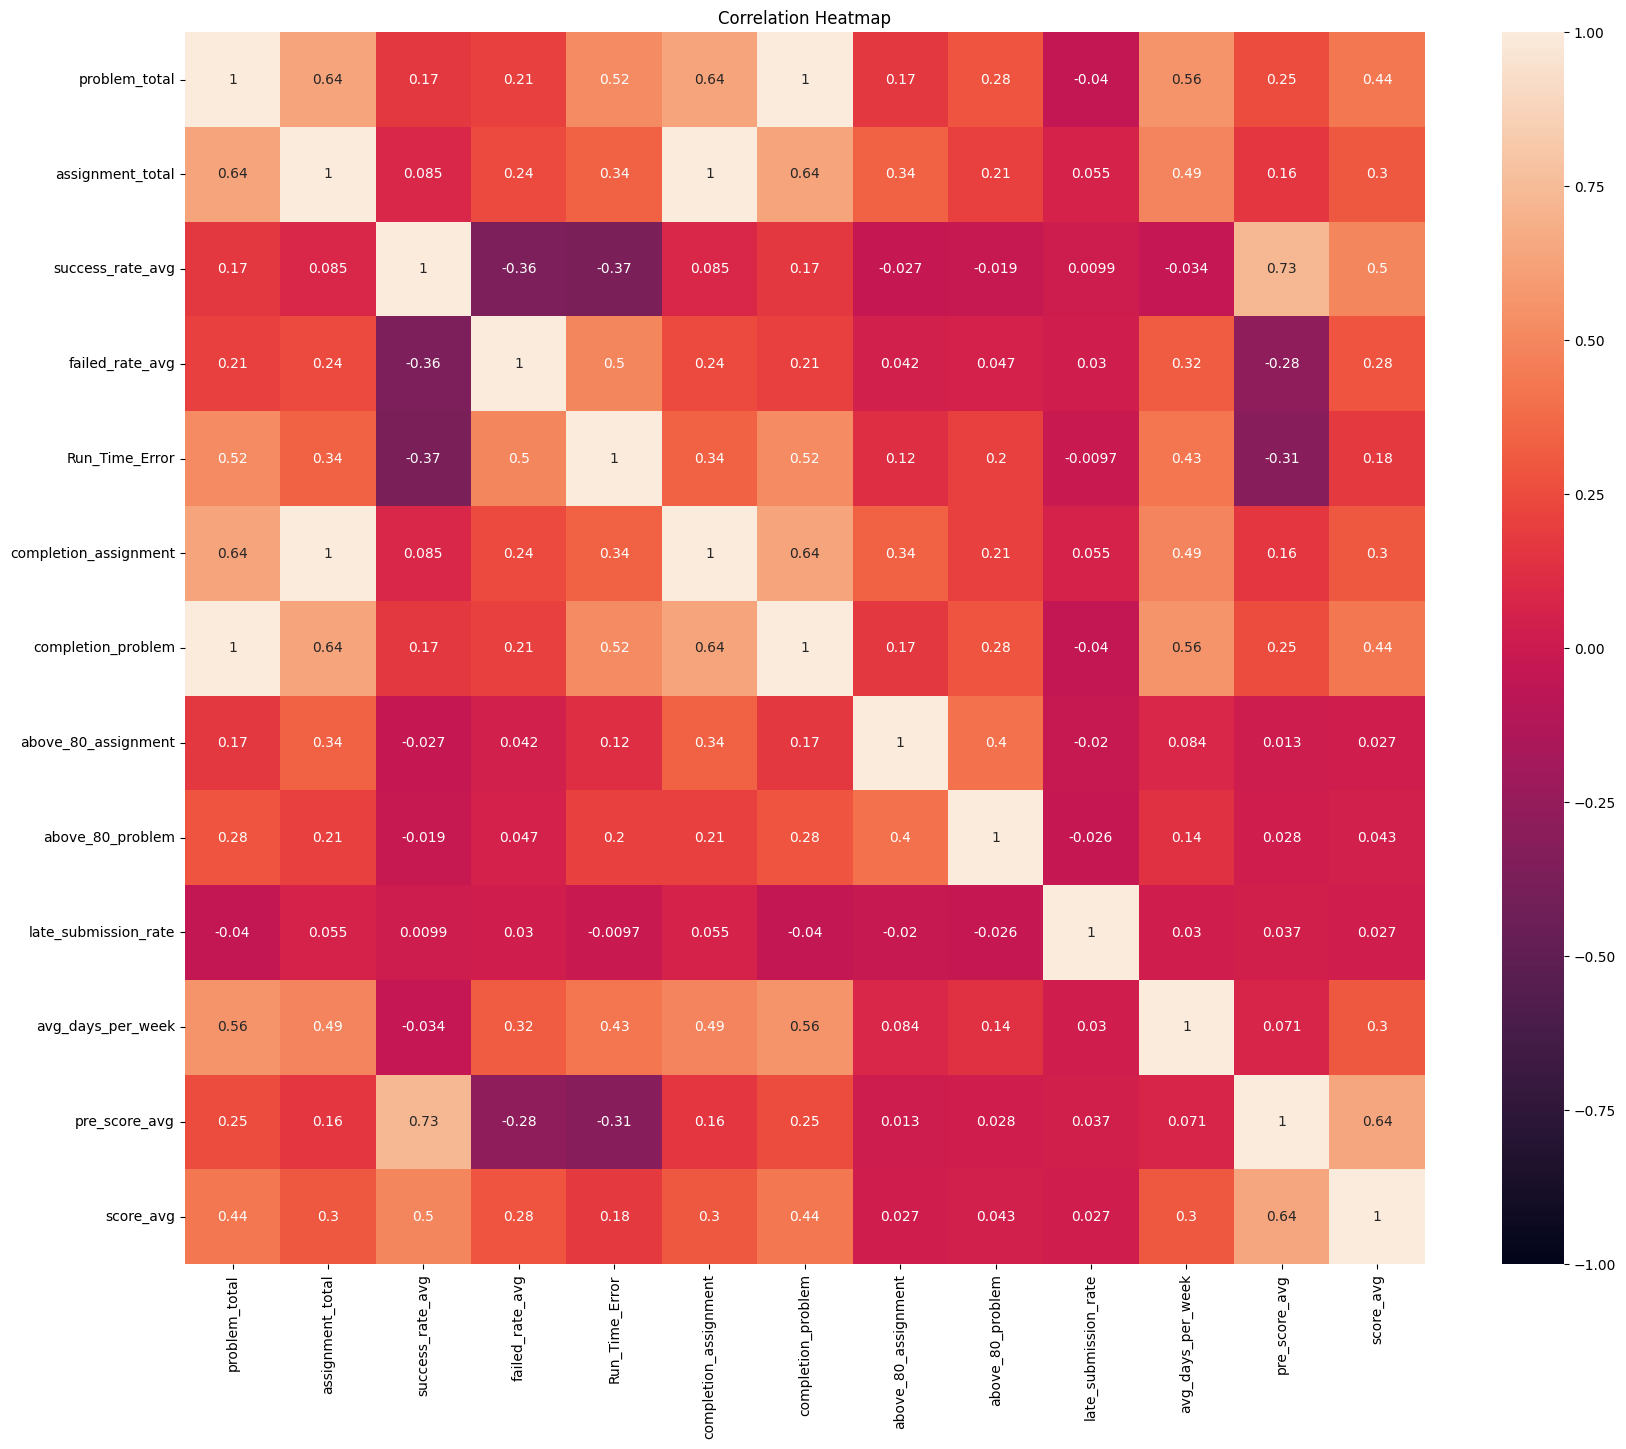

In [90]:
# Vẽ biểu đồ heatmap tương quan
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [91]:
# Loại bỏ các cột được chỉ định từ full_df_temp để phân tích tiếp
full_df_temp.drop(columns=['completion_assignment', 'completion_problem', 'score_avg'], inplace = True)

In [92]:
# Tính ma trận tương quan sau khi loại bỏ các cột
corr_matrix_after = full_df_temp.drop(columns=['username']).corr()

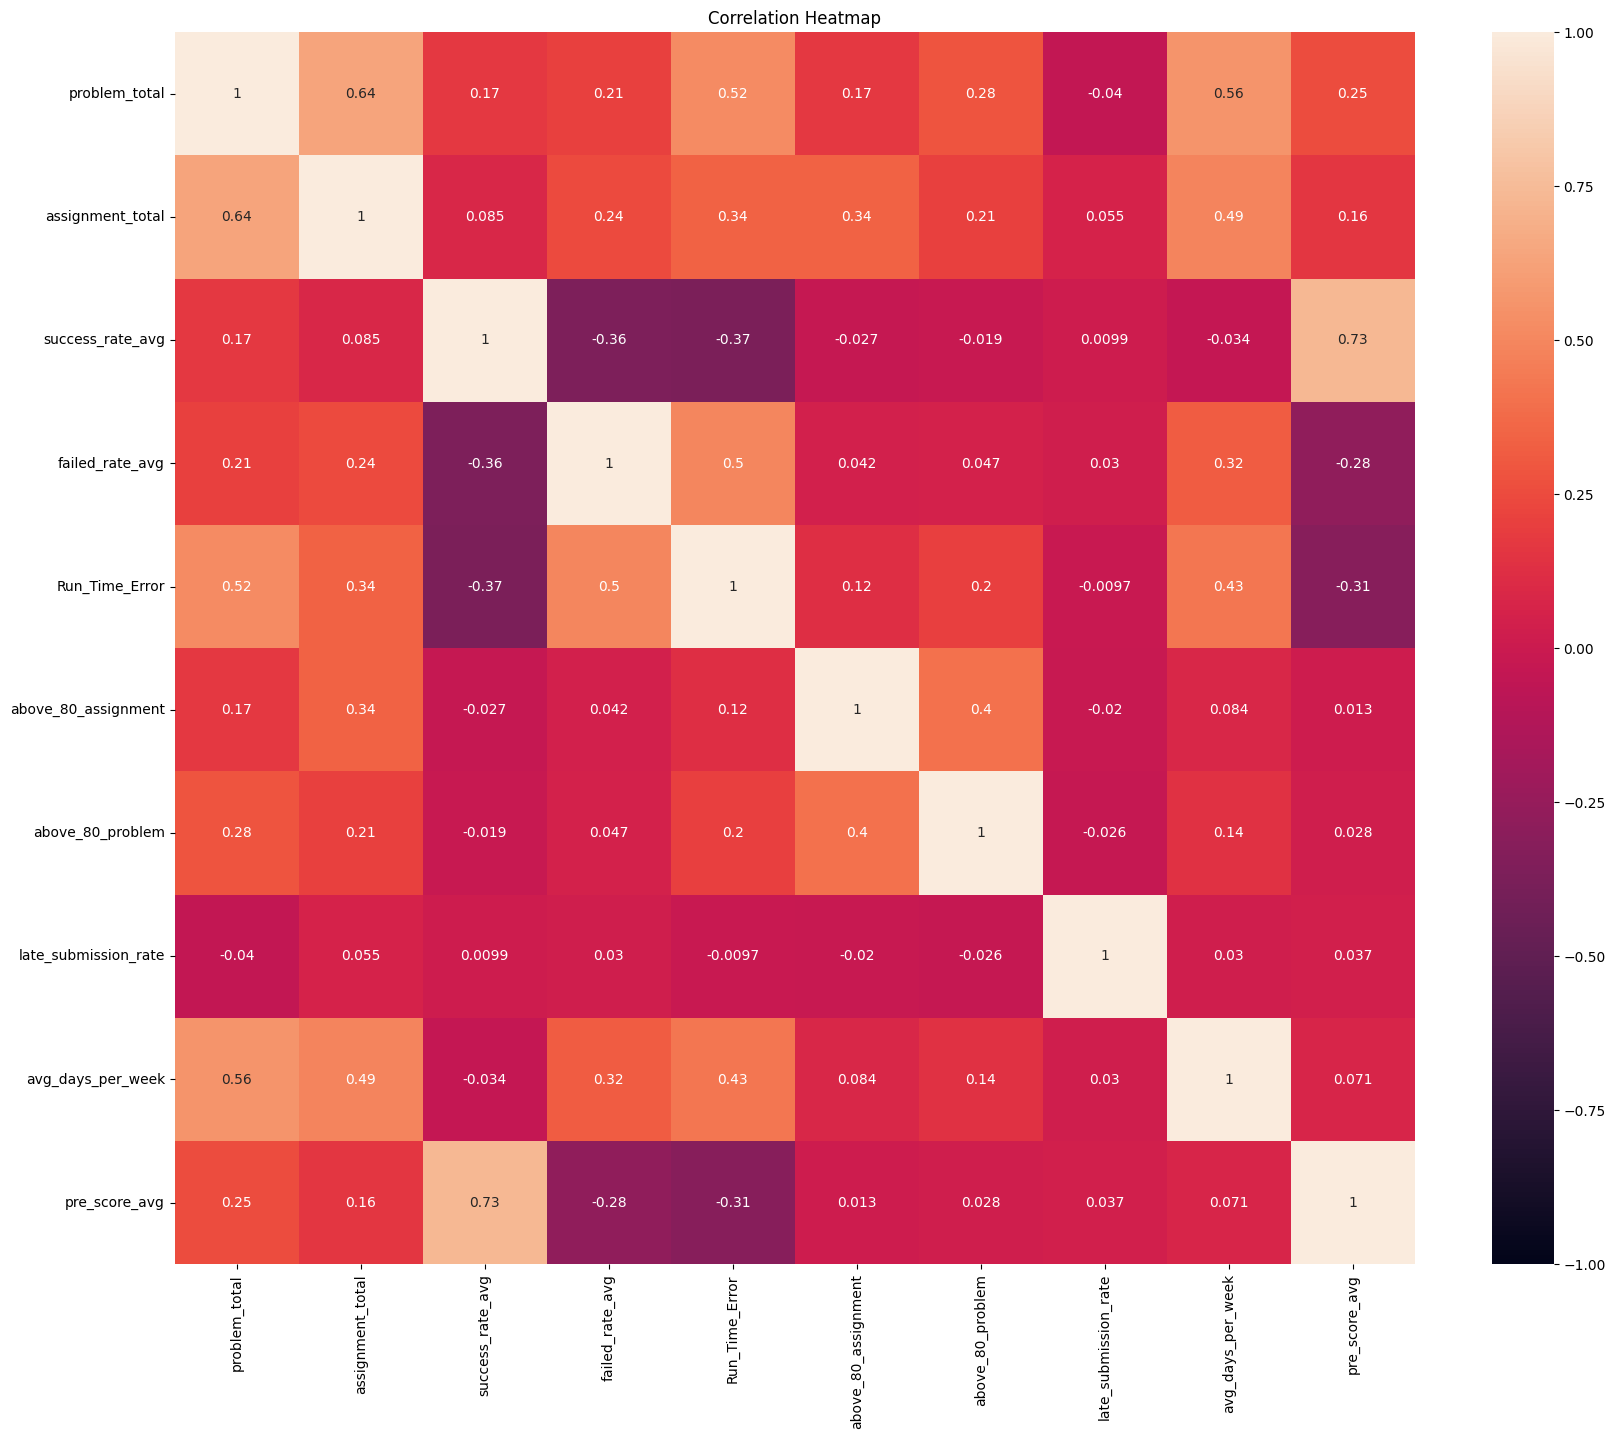

In [93]:
# Vẽ biểu đồ heatmap tương quan sau khi loại bỏ các cột
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix_after, annot=True, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [94]:
full_df_temp.columns

Index(['username', 'problem_total', 'assignment_total', 'success_rate_avg',
       'failed_rate_avg', 'Run_Time_Error', 'above_80_assignment',
       'above_80_problem', 'late_submission_rate', 'avg_days_per_week',
       'pre_score_avg'],
      dtype='object')

In [ ]:
full_df_temp.to_csv('full_df_feature.csv', index=False)

# Xử lý missing values và scale data

In [95]:
# Xác định các cột
numeric_features = full_df_temp.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = full_df_temp.select_dtypes(include=['object']).drop(["username"], axis=1, errors='ignore').columns.tolist()

In [96]:
numeric_features

['problem_total',
 'assignment_total',
 'success_rate_avg',
 'failed_rate_avg',
 'Run_Time_Error',
 'above_80_assignment',
 'above_80_problem',
 'late_submission_rate',
 'avg_days_per_week',
 'pre_score_avg']

In [97]:
categorical_features

[]

In [98]:
# Pipeline cho dữ liệu số
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Điền giá trị thiếu bằng 0
    ('scaler', StandardScaler())                 # Chuẩn hóa dữ liệu
])

In [99]:
# Pipeline cho dữ liệu phân loại (nếu cần)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))  # Điền giá trị thiếu bằng giá trị phổ biến nhất
])

In [100]:
# Tạo ColumnTransformer để áp dụng pipeline cho từng nhóm cột
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [101]:
# Kết hợp preprocessor vào pipeline chính
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [102]:
# Áp dụng pipeline cho dữ liệu
full_df_processed = pipeline.fit_transform(full_df_temp)

In [103]:
# Chuyển đổi kết quả thành DataFrame
processed_columns = numeric_features + categorical_features + ['username']
full_df_processed_df = pd.DataFrame(full_df_processed, columns=processed_columns)

In [104]:
full_df_processed_df

,problem_total,assignment_total,success_rate_avg,failed_rate_avg,Run_Time_Error,above_80_assignment,above_80_problem,late_submission_rate,avg_days_per_week,pre_score_avg,username
0,-0.501164,-0.061584,0.168114,0.052935,-0.302862,-0.100878,-0.164002,-0.196973,-0.774506,0.212652,00b6dd4fc7eb817e03708c532016ef30ce564a61
1,0.464209,0.468462,-0.108019,0.281601,1.032,-0.100878,-0.164002,-0.196973,-0.019768,0.202299,00bef8afee8f3c595d535c9c03c490cac1a4f021
2,0.102194,-0.061584,-0.288676,0.431205,-0.525339,-0.100878,-0.164002,-0.196973,0.73497,0.524376,01122b3ef7e59b84189e65985305f575d6bdf83c
3,-0.470996,-0.856652,1.244485,-0.838411,-0.469719,-0.100878,-0.164002,-0.196973,1.489708,0.51044,0134f9f410c65ad0e8c2254a7e9288670e02a183
4,-0.320156,0.203439,1.465903,-1.021768,-0.497529,-0.100878,-0.164002,0.392087,-0.774506,0.856738,013de369c439ab0ead8aa7da64423aa395a8be39
...,...,...,...,...,...,...,...,...,...,...,...
1484,-0.863178,0.468462,1.389319,-0.958348,-0.998102,-0.100878,-0.164002,-0.196973,-0.774506,0.263719,feb8a2859a011c59efd22ed419cb69288fe03627
1485,0.434041,-0.326607,-0.252517,0.401261,-0.024765,-0.100878,-0.164002,-0.196973,-0.019768,0.677584,fef4a3263ed9a8ab14d457694bb8fd86ccd98312
1486,1.127902,-0.326607,-0.727886,0.794915,1.004191,-0.100878,-0.164002,-0.196973,2.999185,-0.123021,ff12d6e2ab80696ed8e22fbe5497e96c68d29076
1487,-0.863178,-0.061584,-0.171735,0.334365,-0.608767,-0.100878,-0.164002,-0.196973,-1.529245,-0.557901,ff3fa2ec64294f37ae968159f810ebeda7966c51


In [105]:
full_df_temp = full_df_processed_df

In [106]:
full_df_temp.to_csv('final_full_df_feature.csv', index=False)

# Chia tập train, test

## QT

In [108]:
merged_df_qt = pd.merge(full_df_temp, df_qt, left_on='username', right_on='hash', how='left')

In [109]:
train_df_qt = merged_df_qt.dropna(subset=['diemqt'])

# Tạo mặt nạ cho các record có giá trị NaN trong cột điểm diemqt
mask_qt =  merged_df_qt['diemqt'].isna()

# Tách các record có giá trị NaN trong cột điểm TH thành tập X_test
test_df_qt = merged_df_qt[mask_qt]

In [110]:
train_df_qt

,problem_total,assignment_total,success_rate_avg,failed_rate_avg,Run_Time_Error,above_80_assignment,above_80_problem,late_submission_rate,avg_days_per_week,pre_score_avg,username,hash,diemqt
0,-0.501164,-0.061584,0.168114,0.052935,-0.302862,-0.100878,-0.164002,-0.196973,-0.774506,0.212652,00b6dd4fc7eb817e03708c532016ef30ce564a61,00b6dd4fc7eb817e03708c532016ef30ce564a61,7.5
1,0.464209,0.468462,-0.108019,0.281601,1.032,-0.100878,-0.164002,-0.196973,-0.019768,0.202299,00bef8afee8f3c595d535c9c03c490cac1a4f021,00bef8afee8f3c595d535c9c03c490cac1a4f021,7
2,0.102194,-0.061584,-0.288676,0.431205,-0.525339,-0.100878,-0.164002,-0.196973,0.73497,0.524376,01122b3ef7e59b84189e65985305f575d6bdf83c,01122b3ef7e59b84189e65985305f575d6bdf83c,9
4,-0.320156,0.203439,1.465903,-1.021768,-0.497529,-0.100878,-0.164002,0.392087,-0.774506,0.856738,013de369c439ab0ead8aa7da64423aa395a8be39,013de369c439ab0ead8aa7da64423aa395a8be39,10
5,0.826223,0.468462,0.377094,-0.120122,0.058664,-0.100878,-0.164002,-0.196973,-0.019768,0.037326,014c59c6433fd764a0b08de6ffeb757eaf60aa73,014c59c6433fd764a0b08de6ffeb757eaf60aa73,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,-0.591667,-0.326607,0.182374,0.041126,-0.469719,-0.100878,-0.164002,-0.196973,-0.019768,-0.008068,840d07858c03f80f4695056e2cc7d0c474b83a25,840d07858c03f80f4695056e2cc7d0c474b83a25,9
797,1.248574,2.588646,-0.28898,0.431456,1.421335,-0.100878,-0.164002,-0.196973,0.73497,-0.264571,844f5db2e7e31ae51eba025480679ed7e4708ac6,844f5db2e7e31ae51eba025480679ed7e4708ac6,8
798,-0.320156,0.203439,-0.284011,0.427341,-0.191623,-0.100878,-0.164002,-0.196973,-0.774506,-0.621648,845acd04a77b3d1b623f255d9f9f8eae90892dab,845acd04a77b3d1b623f255d9f9f8eae90892dab,6.5
799,1.550253,1.263531,-0.991612,1.013307,2.923055,-0.100878,-0.164002,-0.196973,1.489708,-0.600865,8460eaaf887a6289fb156f7562fb739ba8e9629e,8460eaaf887a6289fb156f7562fb739ba8e9629e,10


In [111]:
test_df_qt

,problem_total,assignment_total,success_rate_avg,failed_rate_avg,Run_Time_Error,above_80_assignment,above_80_problem,late_submission_rate,avg_days_per_week,pre_score_avg,username,hash,diemqt
3,-0.470996,-0.856652,1.244485,-0.838411,-0.469719,-0.100878,-0.164002,-0.196973,1.489708,0.51044,0134f9f410c65ad0e8c2254a7e9288670e02a183,NaN,NaN
20,-0.380492,-0.856652,0.124144,0.089347,-0.302862,-0.100878,-0.164002,-0.196973,-0.774506,-0.098263,035f97702f2c01d26ab1fae8f39ea2f98a0caa3c,NaN,NaN
40,-1.738047,-1.651721,1.984851,-1.45151,-1.025912,-0.100878,-0.164002,-0.196973,-1.529245,1.058733,06024da8147b5cf6105beb4c403f67cf1ff0aea1,06024da8147b5cf6105beb4c403f67cf1ff0aea1,NaN
68,-0.380492,-0.856652,-0.475689,0.58607,0.030854,-0.100878,-0.164002,-0.196973,0.73497,-0.742411,0aaebc88f6106684d6993c156104c1ef36cf94e0,NaN,NaN
80,0.072026,-0.326607,0.377094,-0.120122,-0.553148,-0.100878,-0.164002,-0.196973,0.73497,0.777948,0bf111a9caedf02804f6991792490e63bc21058a,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,-0.863178,0.468462,1.389319,-0.958348,-0.998102,-0.100878,-0.164002,-0.196973,-0.774506,0.263719,feb8a2859a011c59efd22ed419cb69288fe03627,NaN,NaN
1485,0.434041,-0.326607,-0.252517,0.401261,-0.024765,-0.100878,-0.164002,-0.196973,-0.019768,0.677584,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,NaN,NaN
1486,1.127902,-0.326607,-0.727886,0.794915,1.004191,-0.100878,-0.164002,-0.196973,2.999185,-0.123021,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,NaN,NaN
1487,-0.863178,-0.061584,-0.171735,0.334365,-0.608767,-0.100878,-0.164002,-0.196973,-1.529245,-0.557901,ff3fa2ec64294f37ae968159f810ebeda7966c51,NaN,NaN


In [112]:
# Chuyển đổi cột 'diemqt' sang kiểu số, các giá trị không phải số sẽ thành NaN
train_df_qt['diemqt'] = pd.to_numeric(train_df_qt['diemqt'], errors='coerce')

# Điền các giá trị NaN bằng 0 (hoặc giá trị mặc định khác nếu bạn muốn)
train_df_qt.fillna(0, inplace=True)

<ipython-input-112-bc85272f503f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_qt['diemqt'] = pd.to_numeric(train_df_qt['diemqt'], errors='coerce')
<ipython-input-112-bc85272f503f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_qt.fillna(0, inplace=True)


In [113]:
X_qt = train_df_qt.iloc[:, 0:-3].values
y_qt = train_df_qt.iloc[:, -1].values
# X_qt = train_df_qt.drop(columns=['username', 'hash', 'diemqt'])
# y_qt = train_df_qt['diemqt']

In [114]:
X_train_qt, X_test_qt, y_train_qt, y_test_qt = train_test_split(X_qt, y_qt, test_size=0.2, random_state=42)

In [115]:
pd.DataFrame(X_train_qt)

,0,1,2,3,4,5,6,7,8,9
0,0.58488,0.733485,0.858634,-0.518886,-0.44191,-0.100878,-0.164002,-0.196973,-0.019768,0.380808
1,-1.587208,-1.386698,0.546798,-0.260654,-1.053721,-0.100878,-0.164002,-0.196973,-1.529245,-0.436435
2,-1.466536,-0.061584,-1.316031,1.28196,-0.664387,-0.100878,-0.164002,-0.196973,-0.019768,-2.269594
3,0.856391,0.733485,-0.020625,0.20923,-0.080385,-0.100878,-0.164002,-0.196973,2.244446,0.272738
4,1.097734,-0.59163,-0.114846,0.287255,0.670475,-0.100878,-0.164002,-0.196973,-0.774506,-0.126899
...,...,...,...,...,...,...,...,...,...,...
599,-1.738047,-1.651721,-2.422086,-3.641147,-0.970292,-0.100878,-0.164002,-0.196973,-1.529245,-3.441007
600,-1.195025,-0.856652,-0.686431,0.760586,-0.775625,-0.100878,-0.164002,-0.196973,-0.019768,-0.803195
601,0.072026,-0.856652,-2.069531,1.905935,0.614856,-0.100878,-0.164002,-0.196973,-0.774506,-3.075917
602,0.313369,0.733485,-0.448831,0.563829,-0.024765,-0.100878,-0.164002,1.292528,1.489708,0.408349


## TH

In [116]:
merged_df_th = pd.merge(full_df_temp, df_th, left_on='username', right_on='hash', how='left')

In [117]:
train_df_th = merged_df_th.dropna(subset=['TH'])

# Tạo mặt nạ cho các record có giá trị NaN trong cột điểm diemqt
mask_th =  merged_df_th['TH'].isna()

# Tách các record có giá trị NaN trong cột điểm TH thành tập X_test
test_df_th = merged_df_th[mask_th]

In [118]:
# Chuyển đổi cột 'TH' sang kiểu số, các giá trị không phải số sẽ thành NaN
train_df_th['TH'] = pd.to_numeric(train_df_th['TH'], errors='coerce')

# Điền các giá trị NaN bằng 0 (hoặc giá trị mặc định khác nếu bạn muốn)
train_df_th.fillna(0, inplace=True)

<ipython-input-118-cbcb9b412049>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_th['TH'] = pd.to_numeric(train_df_th['TH'], errors='coerce')
<ipython-input-118-cbcb9b412049>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_th.fillna(0, inplace=True)


In [119]:
X_th = train_df_th.iloc[:, 0:-3].values
y_th = train_df_th.iloc[:, -1].values
# X_th = train_df_th.drop(columns=['username', 'hash', 'TH'])
# y_th = train_df_th['TH']

In [120]:
X_train_th, X_test_th, y_train_th, y_test_th = train_test_split(X_th, y_th, test_size=0.2, random_state=42)

In [121]:
pd.DataFrame(X_train_th)

,0,1,2,3,4,5,6,7,8,9
0,0.58488,0.733485,0.858634,-0.518886,-0.44191,-0.100878,-0.164002,-0.196973,-0.019768,0.380808
1,-1.587208,-1.386698,0.546798,-0.260654,-1.053721,-0.100878,-0.164002,-0.196973,-1.529245,-0.436435
2,-1.466536,-0.061584,-1.316031,1.28196,-0.664387,-0.100878,-0.164002,-0.196973,-0.019768,-2.269594
3,0.856391,0.733485,-0.020625,0.20923,-0.080385,-0.100878,-0.164002,-0.196973,2.244446,0.272738
4,1.097734,-0.59163,-0.114846,0.287255,0.670475,-0.100878,-0.164002,-0.196973,-0.774506,-0.126899
...,...,...,...,...,...,...,...,...,...,...
599,-1.738047,-1.651721,-2.422086,-3.641147,-0.970292,-0.100878,-0.164002,-0.196973,-1.529245,-3.441007
600,-1.195025,-0.856652,-0.686431,0.760586,-0.775625,-0.100878,-0.164002,-0.196973,-0.019768,-0.803195
601,0.072026,-0.856652,-2.069531,1.905935,0.614856,-0.100878,-0.164002,-0.196973,-0.774506,-3.075917
602,0.313369,0.733485,-0.448831,0.563829,-0.024765,-0.100878,-0.164002,1.292528,1.489708,0.408349


## TBTL

In [122]:
merged_df_tbtl = pd.merge(full_df_temp, df_tbtl, on='username', how='left')

In [123]:
train_df_tbtl = merged_df_tbtl.dropna(subset=['TBTL'])
mask_tbtl =  merged_df_tbtl['TBTL'].isna()
test_df_tbtl = merged_df_tbtl[mask_tbtl]

In [124]:
train_df_tbtl

,problem_total,assignment_total,success_rate_avg,failed_rate_avg,Run_Time_Error,above_80_assignment,above_80_problem,late_submission_rate,avg_days_per_week,pre_score_avg,username,TBTL
0,-0.501164,-0.061584,0.168114,0.052935,-0.302862,-0.100878,-0.164002,-0.196973,-0.774506,0.212652,00b6dd4fc7eb817e03708c532016ef30ce564a61,7.24
1,0.464209,0.468462,-0.108019,0.281601,1.032,-0.100878,-0.164002,-0.196973,-0.019768,0.202299,00bef8afee8f3c595d535c9c03c490cac1a4f021,8.11
2,0.102194,-0.061584,-0.288676,0.431205,-0.525339,-0.100878,-0.164002,-0.196973,0.73497,0.524376,01122b3ef7e59b84189e65985305f575d6bdf83c,7.30
3,-0.470996,-0.856652,1.244485,-0.838411,-0.469719,-0.100878,-0.164002,-0.196973,1.489708,0.51044,0134f9f410c65ad0e8c2254a7e9288670e02a183,8.63
4,-0.320156,0.203439,1.465903,-1.021768,-0.497529,-0.100878,-0.164002,0.392087,-0.774506,0.856738,013de369c439ab0ead8aa7da64423aa395a8be39,8.20
...,...,...,...,...,...,...,...,...,...,...,...,...
796,-0.591667,-0.326607,0.182374,0.041126,-0.469719,-0.100878,-0.164002,-0.196973,-0.019768,-0.008068,840d07858c03f80f4695056e2cc7d0c474b83a25,7.67
797,1.248574,2.588646,-0.28898,0.431456,1.421335,-0.100878,-0.164002,-0.196973,0.73497,-0.264571,844f5db2e7e31ae51eba025480679ed7e4708ac6,7.54
798,-0.320156,0.203439,-0.284011,0.427341,-0.191623,-0.100878,-0.164002,-0.196973,-0.774506,-0.621648,845acd04a77b3d1b623f255d9f9f8eae90892dab,7.49
799,1.550253,1.263531,-0.991612,1.013307,2.923055,-0.100878,-0.164002,-0.196973,1.489708,-0.600865,8460eaaf887a6289fb156f7562fb739ba8e9629e,8.94


In [125]:
test_df_tbtl

,problem_total,assignment_total,success_rate_avg,failed_rate_avg,Run_Time_Error,above_80_assignment,above_80_problem,late_submission_rate,avg_days_per_week,pre_score_avg,username,TBTL
394,-1.4062,-1.386698,0.365558,-0.110569,-0.803435,-0.100878,-0.164002,-0.196973,-0.774506,-0.254362,410357eb9129023509cfaf8d38be61c050bb3b05,NaN
625,-1.828551,-1.651721,-2.422086,-3.641147,-0.942483,-0.100878,-0.164002,-0.196973,-1.529245,-3.441007,67212308d026508fd5b6942ffbbdd7b0be2e89de,NaN
801,1.067566,-0.326607,1.839567,-1.3312,-0.692196,-0.100878,-0.164002,-0.196973,1.489708,1.065588,84a17972cc6d29489bbe205a9e7feb8745726fbc,NaN
802,0.58488,-0.061584,1.015325,-0.648642,-0.330671,-0.100878,-0.164002,-0.196973,0.73497,0.715486,84b6b2d70924066c8345f2bc2281791ae3188da2,NaN
803,0.977063,1.263531,-0.663843,0.741881,1.616002,-0.100878,-0.164002,-0.196973,0.73497,-0.476005,851d9a4b9b8e236f2d62282ddf06fae57b7d9492,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1484,-0.863178,0.468462,1.389319,-0.958348,-0.998102,-0.100878,-0.164002,-0.196973,-0.774506,0.263719,feb8a2859a011c59efd22ed419cb69288fe03627,NaN
1485,0.434041,-0.326607,-0.252517,0.401261,-0.024765,-0.100878,-0.164002,-0.196973,-0.019768,0.677584,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,NaN
1486,1.127902,-0.326607,-0.727886,0.794915,1.004191,-0.100878,-0.164002,-0.196973,2.999185,-0.123021,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,NaN
1487,-0.863178,-0.061584,-0.171735,0.334365,-0.608767,-0.100878,-0.164002,-0.196973,-1.529245,-0.557901,ff3fa2ec64294f37ae968159f810ebeda7966c51,NaN


In [126]:
# Chuyển đổi cột 'TBTL' sang kiểu số, các giá trị không phải số sẽ thành NaN
train_df_tbtl['TBTL'] = pd.to_numeric(train_df_tbtl['TBTL'], errors='coerce')

# Điền các giá trị NaN bằng 0 (hoặc giá trị mặc định khác nếu bạn muốn)
train_df_tbtl.fillna(0, inplace=True)

<ipython-input-126-f5c0b5e77c18>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_tbtl['TBTL'] = pd.to_numeric(train_df_tbtl['TBTL'], errors='coerce')
<ipython-input-126-f5c0b5e77c18>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_tbtl.fillna(0, inplace=True)


In [127]:
X_tbtl = train_df_tbtl.iloc[:, 0:-2].values
y_tbtl = train_df_tbtl.iloc[:, -1].values

In [128]:
X_train_tbtl, X_test_tbtl, y_train_tbtl, y_test_tbtl = train_test_split(X_tbtl, y_tbtl, test_size=0.2, random_state=42)

In [129]:
pd.DataFrame(X_train_tbtl)

,0,1,2,3,4,5,6,7,8,9
0,-0.531332,-0.59163,-0.997621,1.018284,-0.859054,-0.100878,-0.164002,-0.196973,-1.529245,-0.29624
1,-1.738047,-1.651721,-2.422086,-3.641147,-0.859054,-0.100878,-0.164002,-0.196973,-1.529245,-3.441007
2,-0.742507,-0.061584,-1.36063,1.318892,0.753904,-0.100878,-0.164002,-0.196973,-0.019768,-0.492825
3,0.343537,0.468462,0.019853,0.17571,-0.024765,-0.100878,-0.164002,-0.196973,0.73497,0.484421
4,0.977063,0.733485,-0.263586,0.410427,-0.024765,-0.100878,-0.164002,-0.196973,1.489708,-0.319339
...,...,...,...,...,...,...,...,...,...,...
634,1.15807,0.733485,0.927186,-0.575654,-0.163813,-0.100878,-0.164002,-0.196973,-0.774506,0.189446
635,-0.380492,-0.856652,-0.042881,0.227661,-0.108194,-0.100878,-0.164002,-0.196973,-0.019768,0.073122
636,1.882099,1.263531,-0.360108,0.490357,1.727241,-0.100878,6.097498,-0.196973,2.244446,-0.336003
637,-0.863178,-0.326607,-1.546173,1.472541,0.420189,-0.100878,-0.164002,-0.196973,-0.019768,-2.038689


## CK

In [130]:
merged_df_ck = pd.merge(full_df_temp, df_ck, left_on='username', right_on='hash', how='left')

In [131]:
train_df_ck = merged_df_ck.dropna(subset=['CK'])

# Tạo mặt nạ cho các record có giá trị NaN trong cột điểm CK
mask_ck =  merged_df_ck['CK'].isna()

# Tách các record có giá trị NaN trong cột điểm thành tập X_test
test_df_ck = merged_df_ck[mask_ck]

In [132]:
# Chuyển đổi cột 'CK' sang kiểu số, các giá trị không phải số sẽ thành NaN
train_df_ck['CK'] = pd.to_numeric(train_df_ck['CK'], errors='coerce')

# Điền các giá trị NaN bằng 0 (hoặc giá trị mặc định khác nếu bạn muốn)
train_df_ck.fillna(0, inplace=True)

<ipython-input-132-4c1e4a082068>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_ck['CK'] = pd.to_numeric(train_df_ck['CK'], errors='coerce')
<ipython-input-132-4c1e4a082068>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_ck.fillna(0, inplace=True)


In [133]:
X_ck = train_df_ck.iloc[:, 0:-3].values
y_ck = train_df_ck.iloc[:, -1].values

In [134]:
X_train_ck, X_test_ck, y_train_ck, y_test_ck = train_test_split(X_ck, y_ck, test_size=0.2, random_state=42)

In [135]:
pd.DataFrame(X_train_ck)

,0,1,2,3,4,5,6,7,8,9
0,0.58488,0.733485,0.858634,-0.518886,-0.44191,-0.100878,-0.164002,-0.196973,-0.019768,0.380808
1,-1.587208,-1.386698,0.546798,-0.260654,-1.053721,-0.100878,-0.164002,-0.196973,-1.529245,-0.436435
2,-1.466536,-0.061584,-1.316031,1.28196,-0.664387,-0.100878,-0.164002,-0.196973,-0.019768,-2.269594
3,0.856391,0.733485,-0.020625,0.20923,-0.080385,-0.100878,-0.164002,-0.196973,2.244446,0.272738
4,1.097734,-0.59163,-0.114846,0.287255,0.670475,-0.100878,-0.164002,-0.196973,-0.774506,-0.126899
...,...,...,...,...,...,...,...,...,...,...
599,-1.738047,-1.651721,-2.422086,-3.641147,-0.970292,-0.100878,-0.164002,-0.196973,-1.529245,-3.441007
600,-1.195025,-0.856652,-0.686431,0.760586,-0.775625,-0.100878,-0.164002,-0.196973,-0.019768,-0.803195
601,0.072026,-0.856652,-2.069531,1.905935,0.614856,-0.100878,-0.164002,-0.196973,-0.774506,-3.075917
602,0.313369,0.733485,-0.448831,0.563829,-0.024765,-0.100878,-0.164002,1.292528,1.489708,0.408349


# Build Model

In [ ]:
models = {
    'XGBoost': XGBRegressor(random_state=42),
    'SVM': SVR(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'LightGBM': LGBMRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'CatBoostRegressor': CatBoostRegressor(random_state=42, verbose=0),
    'AdaBoostRegressor': AdaBoostRegressor(random_state=42)
}


In [ ]:
# Define the hyperparameter grids for each model
param_grids = {
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto'],
        'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    },
    'RandomForest': {
        'n_estimators': [200, 400, 500, 700, 800, 900],
        'max_depth': [15, 20, 25, 50],
        'min_samples_split': [5, 10, 20, 40]
    },
    'XGBoost': {
        'n_estimators': [100, 300, 400, 500],
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1],
        'max_depth': [2, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    'KNN': {
        'n_neighbors': [5, 8, 10, 12, 15, 20],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.2],
        'num_leaves': [20, 30, 40, 50, 100],
        'max_depth': [-1, 10, 20, 30, 40],
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1],
        'max_depth': [3, 4, 5, 10],
    },
    'CatBoostRegressor': {
        'iterations': [100, 200, 300, 400, 500],
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1],
        'depth': [3, 4, 5, 10],
    },
    'AdaBoostRegressor': {
        'n_estimators': [50, 100, 150, 200],
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1],
    }
}

## QT

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define R^2 scorer
r2_scorer = make_scorer(r2_score)

# Dictionaries to store grids and best models for each model
model_grids_qt = {}
best_models_qt = {}

for model_name, model in models.items():
    print(f"\nTraining: {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring=r2_scorer,
        cv=cv,
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X_train_qt, y_train_qt)
    model_grids_qt[model_name] = grid_search

    # Save the grid and best model details
    best_models_qt[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best R^2 for {model_name}: {grid_search.best_score_}\n")


Training: XGBoost...
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best parameters for XGBoost: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.6}
Best R^2 for XGBoost: 0.10796438292626842


Training: SVM...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters for SVM: {'C': 1, 'epsilon': 0.8, 'gamma': 'auto', 'kernel': 'rbf'}
Best R^2 for SVM: 0.11418797502029925


Training: RandomForest...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters for RandomForest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 700}
Best R^2 for RandomForest: 0.09754015999355561


Training: KNN...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'distance'}
Best R^2 for KNN: 0.1160698303469087


Training: LightGBM...
Fitting 5 folds for each of 750 candidates, totalling 3750 fits
[LightG

In [ ]:
# Evaluate and display R^2 on the test set for each model
for model_name, grid in model_grids_qt.items():
    test_r2 = r2_score(y_test_qt, grid.predict(X_test_qt))
    print(f"R^2 score on test set for {model_name}: {test_r2}")

R^2 score on test set for XGBoost: 0.252545134863422
R^2 score on test set for SVM: 0.14260257545456712
R^2 score on test set for RandomForest: 0.26874088807943264
R^2 score on test set for KNN: 0.11896833516151262
R^2 score on test set for LightGBM: 0.1721817040598097
R^2 score on test set for GradientBoosting: 0.2894943806713509
R^2 score on test set for CatBoostRegressor: 0.2399965940187736
R^2 score on test set for AdaBoostRegressor: 0.1314245374247045


## TH

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define R^2 scorer
r2_scorer = make_scorer(r2_score)

# Dictionaries to store grids and best models for each model
model_grids_th = {}
best_models_th = {}

for model_name, model in models.items():
    print(f"\nTraining: {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring=r2_scorer,
        cv=cv,
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X_train_th, y_train_th)
    model_grids_th[model_name] = grid_search

    # Save the grid and best model details
    best_models_th[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best R^2 for {model_name}: {grid_search.best_score_}\n")


Training: XGBoost...
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.6}
Best R^2 for XGBoost: 0.35630112999640673


Training: SVM...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters for SVM: {'C': 1, 'epsilon': 0.8, 'gamma': 'auto', 'kernel': 'rbf'}
Best R^2 for SVM: 0.3153534160285041


Training: RandomForest...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters for RandomForest: {'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 700}
Best R^2 for RandomForest: 0.3667596603459027


Training: KNN...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'uniform'}
Best R^2 for KNN: 0.3137818812683445


Training: LightGBM...
Fitting 5 folds for each of 750 candidates, totalling 3750 fits
[LightGBM]

In [ ]:
# Evaluate and display R^2 on the test set for each model
for model_name, grid in model_grids_th.items():
    test_r2 = r2_score(y_test_th, grid.predict(X_test_th))
    print(f"R^2 score on test set for {model_name}: {test_r2}")

R^2 score on test set for XGBoost: 0.3636816632483052
R^2 score on test set for SVM: 0.34522495921935015
R^2 score on test set for RandomForest: 0.3983951916291666
R^2 score on test set for KNN: 0.31625335323253856
R^2 score on test set for LightGBM: 0.36694308063469483
R^2 score on test set for GradientBoosting: 0.3990291748408479
R^2 score on test set for CatBoostRegressor: 0.3768246241830189
R^2 score on test set for AdaBoostRegressor: 0.31548091340324047


## TBTL

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define R^2 scorer
r2_scorer = make_scorer(r2_score)

# Dictionaries to store grids and best models for each model
model_grids_tbtl = {}
best_models_tbtl = {}

for model_name, model in models.items():
    print(f"\nTraining: {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring=r2_scorer,
        cv=cv,
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X_train_tbtl, y_train_tbtl)
    model_grids_tbtl[model_name] = grid_search

    # Save the grid and best model details
    best_models_tbtl[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best R^2 for {model_name}: {grid_search.best_score_}\n")


Training: XGBoost...
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best parameters for XGBoost: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.6}
Best R^2 for XGBoost: 0.17519478085168094


Training: SVM...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters for SVM: {'C': 1, 'epsilon': 0.6, 'gamma': 'scale', 'kernel': 'rbf'}
Best R^2 for SVM: 0.1612128206453542


Training: RandomForest...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters for RandomForest: {'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 500}
Best R^2 for RandomForest: 0.14856321627554187


Training: KNN...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for KNN: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'weights': 'distance'}
Best R^2 for KNN: 0.15200940706726135


Training: LightGBM...
Fitting 5 folds for each of 750 candidates, totalling 3750 fits


In [ ]:
# Evaluate and display R^2 on the test set for each model
for model_name, grid in model_grids_tbtl.items():
    test_r2 = r2_score(y_test_tbtl, grid.predict(X_test_tbtl))
    print(f"R^2 score on test set for {model_name}: {test_r2}")

R^2 score on test set for XGBoost: 0.17882352404973134
R^2 score on test set for SVM: 0.1402068963433828
R^2 score on test set for RandomForest: 0.16637695030340205
R^2 score on test set for KNN: 0.14325944828570703
R^2 score on test set for LightGBM: 0.17357911810933713
R^2 score on test set for GradientBoosting: 0.14233350367269282
R^2 score on test set for CatBoostRegressor: 0.17700066572972328
R^2 score on test set for AdaBoostRegressor: 0.16691942873469767


## CK

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define R^2 scorer
r2_scorer = make_scorer(r2_score)

# Dictionaries to store grids and best models for each model
model_grids_ck = {}
best_models_ck = {}

for model_name, model in models.items():
    print(f"\nTraining: {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring=r2_scorer,
        cv=cv,
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X_train_ck, y_train_ck)
    model_grids_ck[model_name] = grid_search

    # Save the grid and best model details
    best_models_ck[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best R^2 for {model_name}: {grid_search.best_score_}\n")


Training: XGBoost...
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
Best R^2 for XGBoost: 0.266375266464972


Training: SVM...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters for SVM: {'C': 10, 'epsilon': 0.6, 'gamma': 'auto', 'kernel': 'rbf'}
Best R^2 for SVM: 0.23909790351895674


Training: RandomForest...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters for RandomForest: {'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 200}
Best R^2 for RandomForest: 0.23373461066294965


Training: KNN...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
Best R^2 for KNN: 0.198293666601911


Training: LightGBM...
Fitting 5 folds for each of 750 candidates, totalling 3750 fits
[LightGB

In [ ]:
# Evaluate and display R^2 on the test set for each model
for model_name, grid in model_grids_ck.items():
    test_r2 = r2_score(y_test_ck, grid.predict(X_test_ck))
    print(f"R^2 score on test set for {model_name}: {test_r2}")

R^2 score on test set for XGBoost: 0.24390048234804884
R^2 score on test set for SVM: 0.22413022041021502
R^2 score on test set for RandomForest: 0.24501811474727098
R^2 score on test set for KNN: 0.3184849562600648
R^2 score on test set for LightGBM: 0.1866993518954918
R^2 score on test set for GradientBoosting: 0.1940543318559972
R^2 score on test set for CatBoostRegressor: 0.24730165337587862
R^2 score on test set for AdaBoostRegressor: 0.21844224426755066


# Prediction

In [ ]:
import os
os.makedirs('result_qt', exist_ok=True)
os.makedirs('result_th', exist_ok=True)
os.makedirs('result_tbtl', exist_ok=True)
os.makedirs('result_ck', exist_ok=True)

## QT

In [ ]:
X_test_res_qt = test_df_qt.iloc[:, 0:-3].values
y_pred_res_qt = {model_name: grid.predict(X_test_res_qt) for model_name, grid in model_grids_qt.items()}


In [ ]:
for model_name, predictions in y_pred_res_qt.items():
    result_qt = pd.merge(
        test_df_qt['username'].reset_index(),
        pd.DataFrame(predictions, columns=['predict']),
        left_index=True,
        right_index=True,
        how='left'
    )

    # Save to CSV
    path_qt = f'./result_qt/result_qt_{model_name}.csv'
    result_qt[['username', 'predict']].to_csv(path_qt, header=False, index=False)
    print(f"Predictions saved for QT {model_name} to {path_qt}")

Predictions saved for QT XGBoost to ./result_qt/result_qt_XGBoost.csv
Predictions saved for QT SVM to ./result_qt/result_qt_SVM.csv
Predictions saved for QT RandomForest to ./result_qt/result_qt_RandomForest.csv
Predictions saved for QT KNN to ./result_qt/result_qt_KNN.csv
Predictions saved for QT LightGBM to ./result_qt/result_qt_LightGBM.csv
Predictions saved for QT GradientBoosting to ./result_qt/result_qt_GradientBoosting.csv
Predictions saved for QT CatBoostRegressor to ./result_qt/result_qt_CatBoostRegressor.csv
Predictions saved for QT AdaBoostRegressor to ./result_qt/result_qt_AdaBoostRegressor.csv


## TH

In [ ]:
X_test_res_th = test_df_th.iloc[:, 0:-3].values
y_pred_res_th = {model_name: grid.predict(X_test_res_th) for model_name, grid in model_grids_th.items()}


In [ ]:
for model_name, predictions in y_pred_res_th.items():
    result_th = pd.merge(
        test_df_th['username'].reset_index(),
        pd.DataFrame(predictions, columns=['predict']),
        left_index=True,
        right_index=True,
        how='left'
    )

    # Save to CSV
    path_th = f'./result_th/result_th_{model_name}.csv'
    result_th[['username', 'predict']].to_csv(path_th, header=False, index=False)
    print(f"Predictions saved for TH {model_name} to {path_th}")

Predictions saved for TH XGBoost to ./result_th/result_th_XGBoost.csv
Predictions saved for TH SVM to ./result_th/result_th_SVM.csv
Predictions saved for TH RandomForest to ./result_th/result_th_RandomForest.csv
Predictions saved for TH KNN to ./result_th/result_th_KNN.csv
Predictions saved for TH LightGBM to ./result_th/result_th_LightGBM.csv
Predictions saved for TH GradientBoosting to ./result_th/result_th_GradientBoosting.csv
Predictions saved for TH CatBoostRegressor to ./result_th/result_th_CatBoostRegressor.csv
Predictions saved for TH AdaBoostRegressor to ./result_th/result_th_AdaBoostRegressor.csv


## TBTL

In [ ]:
X_test_res_tbtl = test_df_tbtl.iloc[:, 0:-2].values
y_pred_res_tbtl = {model_name: grid.predict(X_test_res_tbtl) for model_name, grid in model_grids_tbtl.items()}


In [ ]:
for model_name, predictions in y_pred_res_tbtl.items():
    result_tbtl = pd.merge(
        test_df_tbtl['username'].reset_index(),
        pd.DataFrame(predictions, columns=['predict']),
        left_index=True,
        right_index=True,
        how='left'
    )

    # Save to CSV
    path_tbtl = f'./result_tbtl/result_tbtl_{model_name}.csv'
    result_tbtl[['username', 'predict']].to_csv(path_tbtl, header=False, index=False)
    print(f"Predictions saved for TBTL {model_name} to {path_tbtl}")

Predictions saved for TBTL XGBoost to ./result_tbtl/result_tbtl_XGBoost.csv
Predictions saved for TBTL SVM to ./result_tbtl/result_tbtl_SVM.csv
Predictions saved for TBTL RandomForest to ./result_tbtl/result_tbtl_RandomForest.csv
Predictions saved for TBTL KNN to ./result_tbtl/result_tbtl_KNN.csv
Predictions saved for TBTL LightGBM to ./result_tbtl/result_tbtl_LightGBM.csv
Predictions saved for TBTL GradientBoosting to ./result_tbtl/result_tbtl_GradientBoosting.csv
Predictions saved for TBTL CatBoostRegressor to ./result_tbtl/result_tbtl_CatBoostRegressor.csv
Predictions saved for TBTL AdaBoostRegressor to ./result_tbtl/result_tbtl_AdaBoostRegressor.csv


## CK

In [ ]:
X_test_res_ck = test_df_ck.iloc[:, 0:-3].values
y_pred_res_ck = {model_name: grid.predict(X_test_res_ck) for model_name, grid in model_grids_ck.items()}


In [ ]:
for model_name, predictions in y_pred_res_ck.items():
    result_ck = pd.merge(
        test_df_ck['username'].reset_index(),
        pd.DataFrame(predictions, columns=['predict']),
        left_index=True,
        right_index=True,
        how='left'
    )

    # Save to CSV
    path_ck = f'./result_ck/result_ck_{model_name}.csv'
    result_ck[['username', 'predict']].to_csv(path_ck, header=False, index=False)
    print(f"Predictions saved for CK {model_name} to {path_ck}")

Predictions saved for CK XGBoost to ./result_ck/result_ck_XGBoost.csv
Predictions saved for CK SVM to ./result_ck/result_ck_SVM.csv
Predictions saved for CK RandomForest to ./result_ck/result_ck_RandomForest.csv
Predictions saved for CK KNN to ./result_ck/result_ck_KNN.csv
Predictions saved for CK LightGBM to ./result_ck/result_ck_LightGBM.csv
Predictions saved for CK GradientBoosting to ./result_ck/result_ck_GradientBoosting.csv
Predictions saved for CK CatBoostRegressor to ./result_ck/result_ck_CatBoostRegressor.csv
Predictions saved for CK AdaBoostRegressor to ./result_ck/result_ck_AdaBoostRegressor.csv
